## Overview

In [22]:
# Import the necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report



In [23]:
# Reading the data
temp_data = pd.read_csv('/Users/umeshnagar/Downloads/data (2).csv')
# change to datetime in case required to extract datetime feature
temp_data['timestamp'] = pd.to_datetime(temp_data['timestamp'], format='%Y-%m-%d %H:%M:%S%z')
temp_data.head()

,timestamp,part_id,temperature_1,temperature_2,temperature_3,temperature_4,label
0,2024-02-15 05:44:34+05:30,2124077390649042,439.1,424.1,536.0,518.6,0
1,2024-02-15 05:44:35+05:30,2124077390649042,438.9,423.9,535.9,518.7,0
2,2024-02-15 05:44:36+05:30,2124077390649042,438.7,423.6,535.6,518.9,0
3,2024-02-15 05:44:37+05:30,2124077390649042,438.4,423.4,535.4,519.0,0
4,2024-02-15 05:44:38+05:30,2124077390649042,438.2,423.2,535.2,519.2,0


## EDA

In [24]:
temp_data[temp_data['part_id'] == 2124077390649042]

,timestamp,part_id,temperature_1,temperature_2,temperature_3,temperature_4,label
0,2024-02-15 05:44:34+05:30,2124077390649042,439.1,424.1,536.0,518.6,0
1,2024-02-15 05:44:35+05:30,2124077390649042,438.9,423.9,535.9,518.7,0
2,2024-02-15 05:44:36+05:30,2124077390649042,438.7,423.6,535.6,518.9,0
3,2024-02-15 05:44:37+05:30,2124077390649042,438.4,423.4,535.4,519.0,0
4,2024-02-15 05:44:38+05:30,2124077390649042,438.2,423.2,535.2,519.2,0
...,...,...,...,...,...,...,...
299,2024-02-15 05:49:33+05:30,2124077390649042,442.9,428.7,537.8,516.9,0
300,2024-02-15 05:49:34+05:30,2124077390649042,442.7,428.3,537.5,517.0,0
301,2024-02-15 05:49:35+05:30,2124077390649042,442.4,428.1,537.2,517.3,0
302,2024-02-15 05:49:36+05:30,2124077390649042,442.1,427.9,537.1,517.5,0


In [25]:
# Just to check interval between start and end of a part id
dt.datetime.strptime('2024-02-15 05:49:37','%Y-%m-%d %H:%M:%S') - dt.datetime.strptime('2024-02-15 05:44:34','%Y-%m-%d %H:%M:%S') 


datetime.timedelta(seconds=303)

In [26]:
# Get the type of column ensure all columns are having proper datatype
temp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype                    
---  ------         --------------   -----                    
 0   timestamp      100000 non-null  datetime64[ns, UTC+05:30]
 1   part_id        100000 non-null  int64                    
 2   temperature_1  100000 non-null  float64                  
 3   temperature_2  100000 non-null  float64                  
 4   temperature_3  100000 non-null  float64                  
 5   temperature_4  100000 non-null  float64                  
 6   label          100000 non-null  int64                    
dtypes: datetime64[ns, UTC+05:30](1), float64(4), int64(2)
memory usage: 5.3 MB


In [27]:
# Get the total unique count for each part id
temp_data['part_id'].nunique()

295

In [28]:
# get number of labels across part id
label_count = temp_data[['part_id', 'label']].astype(str).drop_duplicates().groupby(['label']).count().reset_index()
label_count

,label,part_id
0,0,276
1,1,19


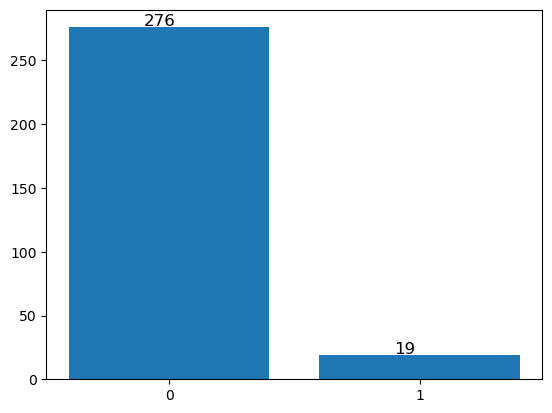

In [29]:
# Visual plot to see the distributions
label_count = temp_data[['part_id', 'label']].astype(str).drop_duplicates().groupby(['label']).count().reset_index()
label_count

plt.bar(x = label_count['label'], height= label_count['part_id'])

def add_counts_over_char(count_df):
    for i, v in enumerate(count_df):
        plt.text(i - 0.1,v+1 ,str(v), color = 'black',size = 12)

add_counts_over_char(label_count['part_id'])

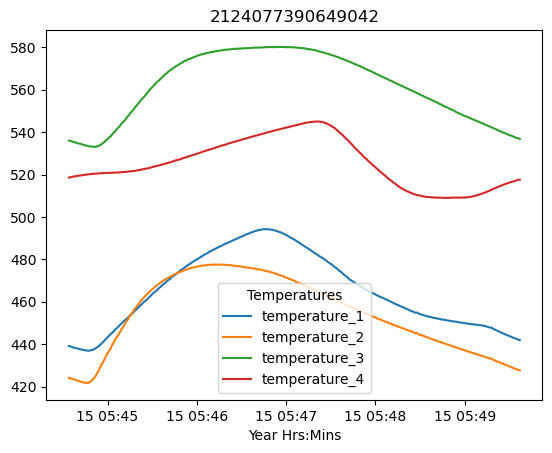

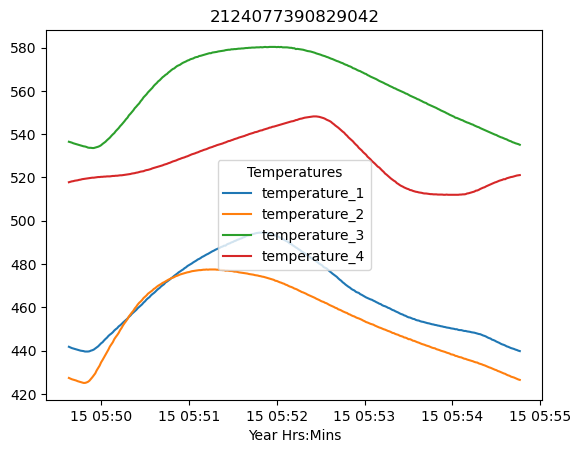

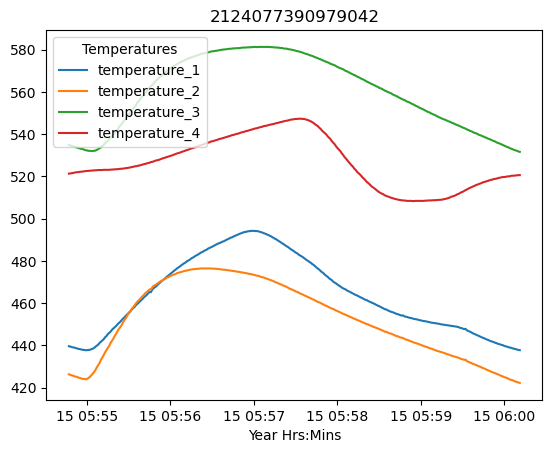

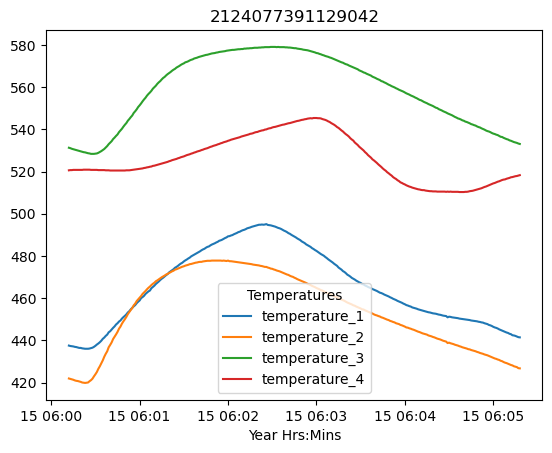

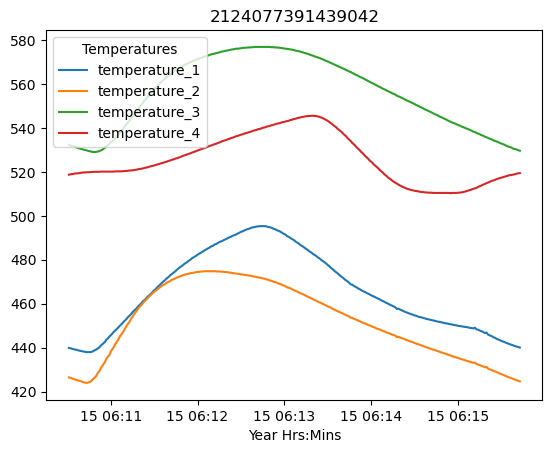

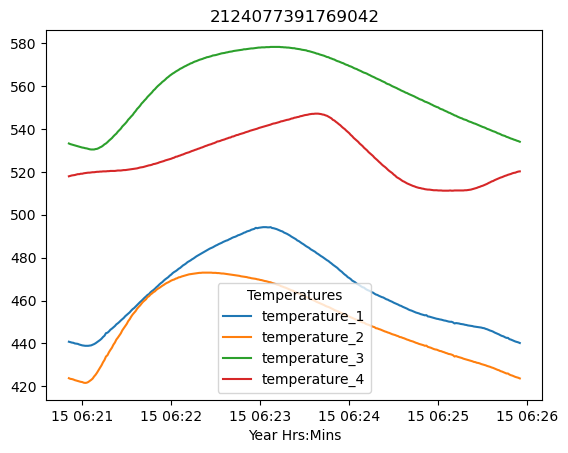

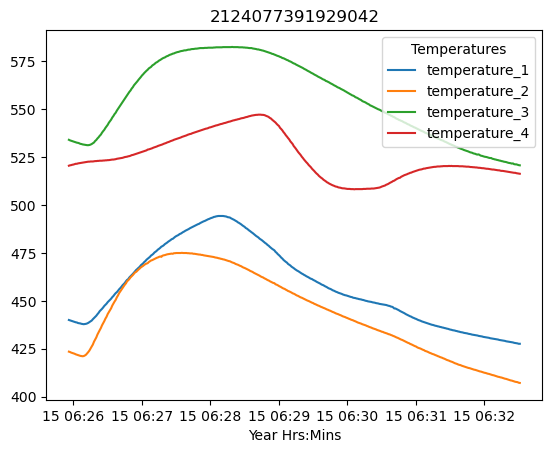

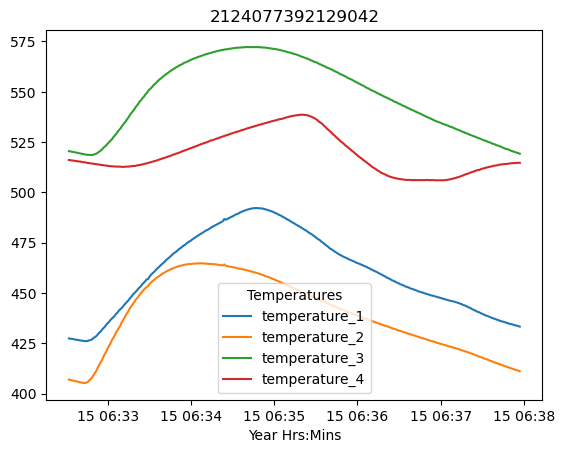

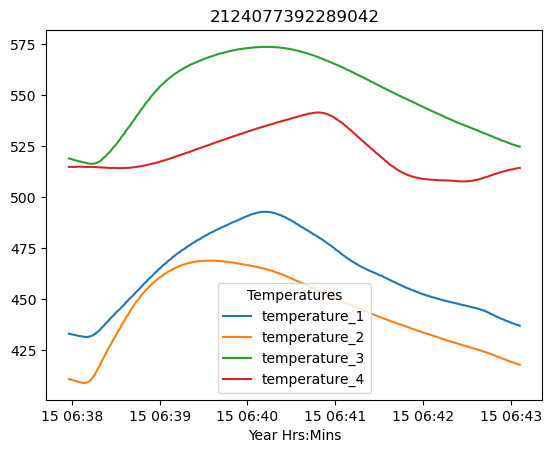

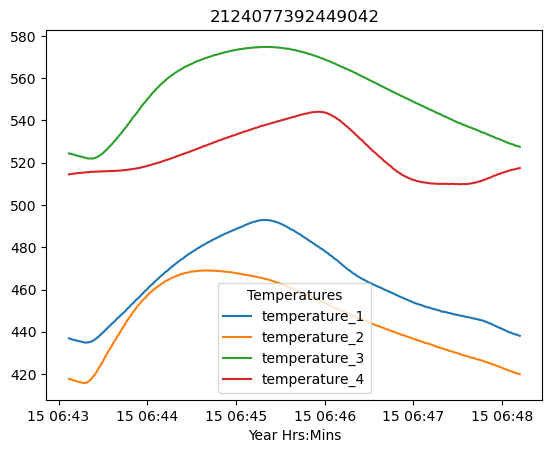

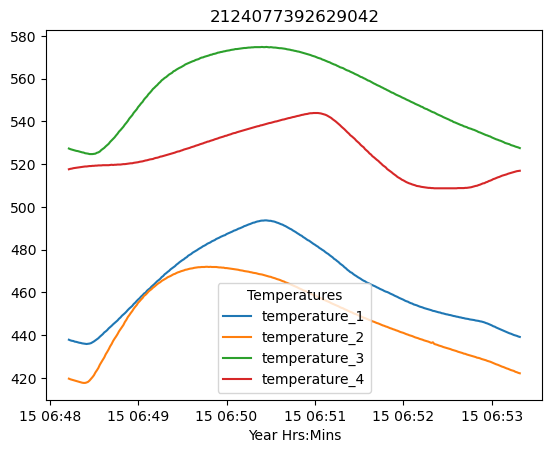

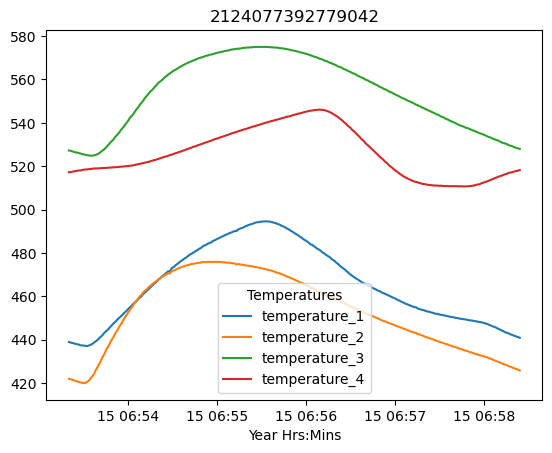

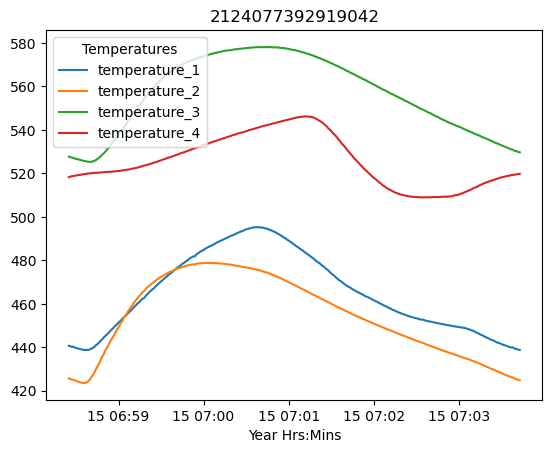

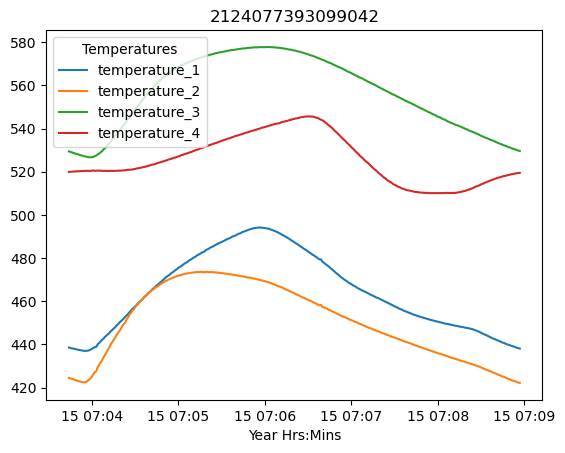

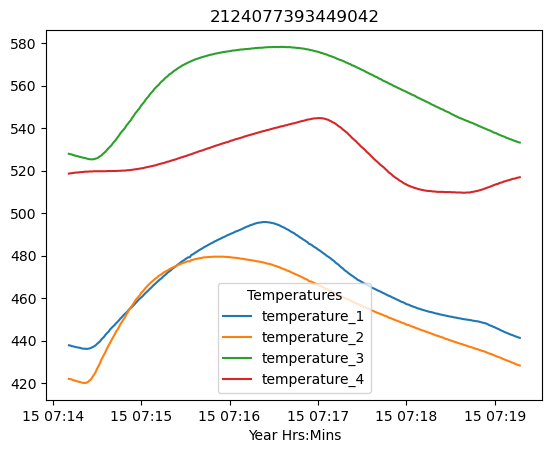

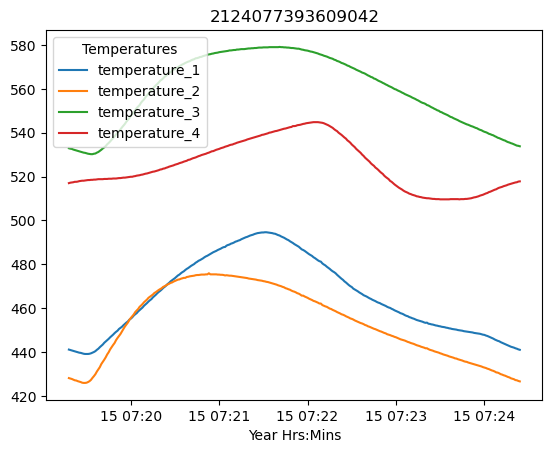

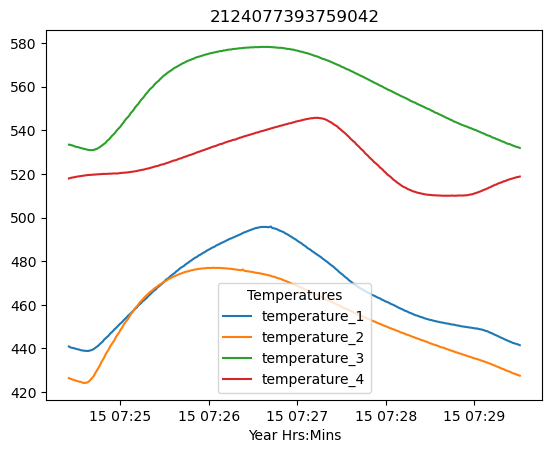

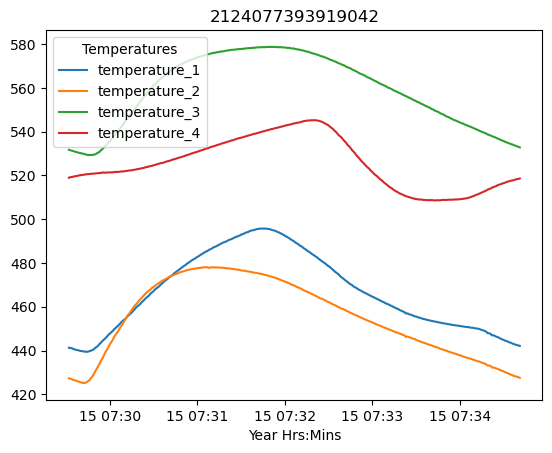

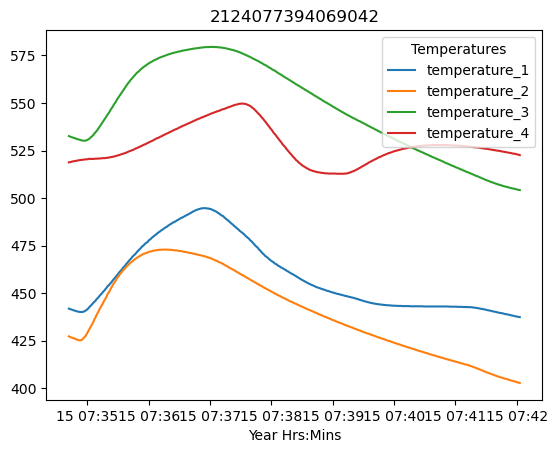

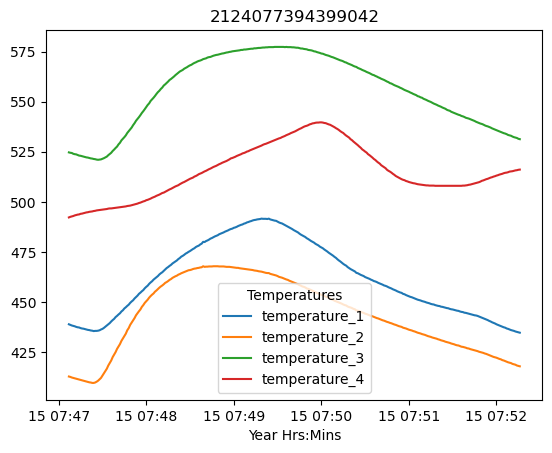

In [30]:
# Plot time series temperature chart for each part id 
for part_id in temp_data['part_id'].unique()[:20]:
    one_id = temp_data[temp_data['part_id'] == part_id]
    plt.plot(one_id['timestamp'], one_id[[temps for temps in temp_data.columns if 'temp' in temps]]) # [[column for column in temp_data.columns if 'temp' in column]])
    plt.legend([temps for temps in temp_data.columns if 'temp' in temps], title='Temperatures')

    plt.xlabel('Year Hrs:Mins')
    plt.title(part_id)

    plt.show() 


### Insights from EDA

## Feature engineering

In [31]:
# Filtered out temperature column dynamically 
all_temp_columns = [temps for temps in temp_data.columns if 'temp' in temps]
all_temp_columns

['temperature_1', 'temperature_2', 'temperature_3', 'temperature_4']

In [32]:
# Create sample statistical features
def create_features(data):
    data['temp_stddev'] = data[all_temp_columns].std(axis = 1)
    data['temp_mean'] = data[all_temp_columns].mean(axis = 1)
    data['temp_min'] = data[all_temp_columns].min(axis = 1)
    data['temp_max'] = data[all_temp_columns].max(axis = 1)
    return data
temp_data = create_features(temp_data)

## Model building

In [33]:
def split_into_XandY(data):
    all_temp_columns = [temps for temps in temp_data.columns if 'temp' in temps]
    X = temp_data[all_temp_columns]
    Y = temp_data['label']
    print(f'Row,Col in X: {X.shape}, Row,Col in X: {Y.shape}')
    return X, Y

X, Y = split_into_XandY(temp_data)

Row,Col in X: (100000, 8), Row,Col in X: (100000,)


In [34]:
# Split into train and test
def split_into_train_test(datax, datay):
    X_data, X_data, y_data, y_data = train_test_split(datax, datay, test_size=0.2, random_state=42,stratify=Y)
    return X_data, X_data, y_data, y_data

X_train, X_test, y_train, y_test  = split_into_train_test(X, Y)

In [35]:
# fit a xgb model
def train_xgb(X_data, y_data):
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    model.fit(X_data, y_data)

    return model

model = train_xgb(X_train, y_train)

### Evaluation

In [44]:
# Generate prediction and calculate the accuracy measures
def prediction(data):
    # Making predictions
    y_pred = model.predict(data)
    # Evaluation
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Evaluate the performance
    accuracy = accuracy_score(y_test, y_pred)
    print("\nAcc:", accuracy)
    precision = precision_score(y_test, y_pred)
    print("\nPrecision:", precision)
    recall = recall_score(y_test, y_pred)
    print("\nRecall:", recall)
    f1 = f1_score(y_test, y_pred)
    print("\nf1:", f1)
    return y_pred

y_pred = prediction(X_test)

Confusion Matrix:
[[18801     5]
 [  667   527]]

Acc: 0.9664

Precision: 0.9906015037593985

Recall: 0.44137353433835846

f1: 0.6106604866743917


In [45]:
# Classification Report (provides precision, recall, F1-score for each class)
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18806
           1       0.99      0.44      0.61      1194

    accuracy                           0.97     20000
   macro avg       0.98      0.72      0.80     20000
weighted avg       0.97      0.97      0.96     20000



## Summary